# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#importing the required libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.linalg import eigh
import pydotplus
import re
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from tqdm import tqdm
import string
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import label_binarize
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import collections
from io import StringIO

/home/blurryface/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#loading the data through sqlite and preprocesing it a little bit.
temp = sqlite3.connect('database.sqlite')
temp = pd.read_sql_query("""SELECT * FROM Reviews WHERE SCORE != 3""", temp)
def partiton(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'
score = temp['Score']
positive_negative = score.map(partiton)
temp['Score'] = positive_negative

In [3]:
#sorting the data in ascending order according to the time stamp
temp.sort_values('Time', inplace=True)
temp.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", sqlite3.connect('database.sqlite'))
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [12]:
#getting rid of the duplicates
final = temp.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [13]:
#Removing all the points where Denominator < Numerator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [14]:
final.shape

(364171, 10)

In [15]:
#Taking top 100k values for the assignment
final = final.iloc[0: 100000,:]

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

#### Doing the text processing for text as well as summary of the review

In [3]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def clean_html(sentence):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, ' ', sentence)
    return cleantext
def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [17]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in tqdm(final['Text'].values):
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

100%|██████████| 100000/100000 [01:38<00:00, 1015.11it/s]


In [18]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [19]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [20]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in tqdm(final['Summary'].values):
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

100%|██████████| 100000/100000 [00:07<00:00, 13670.22it/s]


In [21]:
final['CleanedSummary']=final_string 
final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")

In [22]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [23]:
#Saving the cleaned data for future assignments
clean_data = open("clean_data_1.pickle", "wb")
pickle.dump(final, clean_data)
clean_data.close()

In [4]:
pickle_in = open("clean_data_1.pickle", "rb")
final = pickle.load(pickle_in)

In [5]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [6]:
final.shape

(100000, 12)

In [7]:
scores = final['Score'].get_values()
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in range(0,100000):
    final_scores.append(li(scores[i]))
final_scores = np.asarray(final_scores)
final_scores.shape

(100000,)

# Dividing the whole data into train, CV and test sets

In [8]:
#train data
X_train = final[0: 60000]
Y_train = final_scores[0: 60000]
print(X_train.shape)
print(Y_train.shape)

(60000, 12)
(60000,)


In [9]:
X_CV = final[60000: 80000]
Y_CV = final_scores[60000: 80000]
print(X_CV.shape)
print(Y_CV.shape)

(20000, 12)
(20000,)


In [10]:
#test data
X_test = final[80000: ]
Y_test = final_scores[80000: ]
print(X_test.shape)
print(Y_test.shape)

(20000, 12)
(20000,)


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 1000], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# BOW

In [9]:
count_vect = CountVectorizer(min_df=10)
X_train_bow = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_bow.shape

(60000, 6691)

In [10]:
X_CV_bow = count_vect.transform(X_CV['CleanedText'].values)
X_CV_bow.shape

(20000, 6691)

In [11]:
X_test_bow = count_vect.transform(X_test['CleanedText'].values)
X_test_bow.shape

(20000, 6691)

## Decision tree implementation on BOW

In [12]:
tuned_parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split':[5, 10, 100, 500]}


DT_model = DecisionTreeClassifier(class_weight='balanced')
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_bow, Y_train)

print(model.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=1000, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


## From the above results it can be seen that optimal depth is 1000 and optimal min_samples_split is 5 now getting the train scores and CV scores for different values of depth and min_samples_split.

In [14]:
def scores_for_depth(X, Y):
    max_depths = [1, 5, 10, 50, 100, 500, 1000]
    scores =[]
    for max_depth in tqdm(max_depths):
            clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
            clf.fit(X_train_bow, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [15]:
CV_scores_depth = scores_for_depth(X_CV_bow, Y_CV)

100%|██████████| 7/7 [01:03<00:00,  9.09s/it]


In [16]:
train_scores_depth = scores_for_depth(X_train_bow, Y_train)

100%|██████████| 7/7 [01:03<00:00,  9.04s/it]


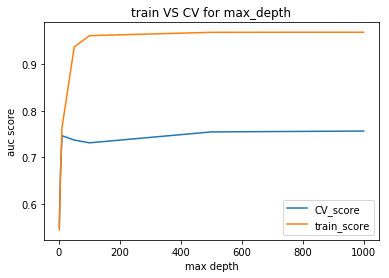

In [17]:
max_depths = [1, 5, 10, 50, 100, 500, 1000]
plt.plot(max_depths, CV_scores_depth, label='CV_score')
plt.plot(max_depths, train_scores_depth, label='train_score')
plt.title('train VS CV for max_depth')
plt.ylabel('auc score')
plt.xlabel('max depth')
plt.legend()
plt.show()

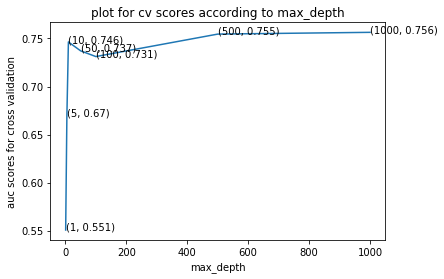

The auc score for each max_depth value for cross validation is :  [0.551 0.67  0.746 0.737 0.731 0.755 0.756]


In [18]:
plt.plot(max_depths, CV_scores_depth)

plt.title('plot for cv scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(CV_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each max_depth value for cross validation is : ", np.round(CV_scores_depth,3))

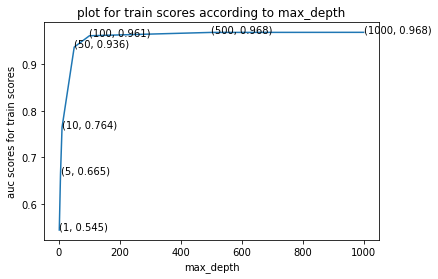

The auc score for each max_depth value for train data is :  [0.545 0.665 0.764 0.936 0.961 0.968 0.968]


In [19]:
plt.plot(max_depths, train_scores_depth)

plt.title('plot for train scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(train_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each max_depth value for train data is : ", np.round(train_scores_depth,3))

In [20]:
def scores_for_splits(X, Y):
    min_samples_splits=[5, 10, 100, 500]
    scores =[]
    for min_samples_split in tqdm(min_samples_splits):
            clf = DecisionTreeClassifier(criterion='gini', max_depth=1000, min_samples_split=min_samples_split)
            clf.fit(X_train_bow, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [21]:
CV_scores_splits = scores_for_splits(X_CV_bow, Y_CV)

100%|██████████| 4/4 [01:04<00:00, 16.21s/it]


In [22]:
train_scores_splits = scores_for_splits(X_train_bow, Y_train)

100%|██████████| 4/4 [01:01<00:00, 15.39s/it]


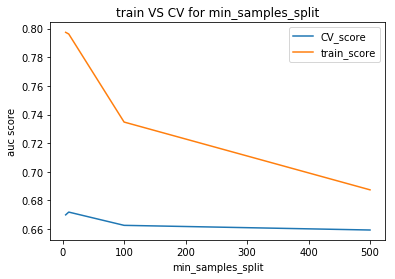

In [23]:
min_samples_splits=[5, 10, 100, 500]
plt.plot(min_samples_splits, CV_scores_splits, label='CV_score')
plt.plot(min_samples_splits, train_scores_splits, label='train_score')
plt.title('train VS CV for min_samples_split')
plt.ylabel('auc score')
plt.xlabel('min_samples_split')
plt.legend()
plt.show()

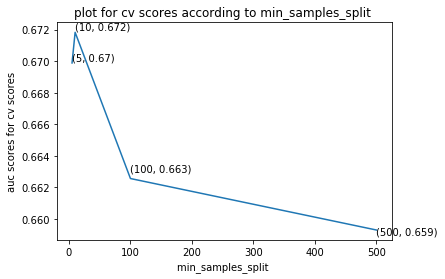

The auc score for each min_samples_split  value for cv data is :  [0.67  0.672 0.663 0.659]


In [24]:
plt.plot(min_samples_splits, CV_scores_splits)

plt.title('plot for cv scores according to min_samples_split ')
for xy in zip(np.round(min_samples_splits, 2), np.round(CV_scores_splits,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('min_samples_split ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each min_samples_split  value for cv data is : ", np.round(CV_scores_splits,3))

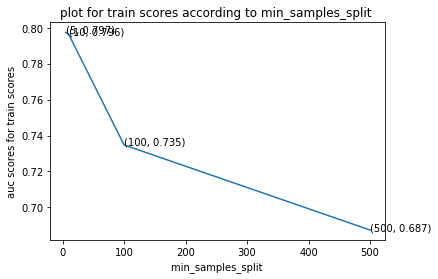

The auc score for each min_samples_split  value for train data is :  [0.797 0.796 0.735 0.687]


In [25]:
plt.plot(min_samples_splits, train_scores_splits)

plt.title('plot for train scores according to min_samples_split ')
for xy in zip(np.round(min_samples_splits, 2), np.round(train_scores_splits,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('min_samples_split ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each min_samples_split  value for train data is : ", np.round(train_scores_splits,3))

## Getting the test data scores

In [31]:
DT_optimal = DecisionTreeClassifier(criterion='gini', max_depth=1000, min_samples_split=5)

# fitting the model
DT_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = DT_optimal.predict_proba(X_test_bow)[:, 1]

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [32]:
print('\nThe auc score for test data for max_depth = {} and min_samples_split = {} is {:2f}'.format(1000, 5, auc_score))


The auc score for test data for max_depth = 1000 and min_samples_split = 5 is 0.666607


In [33]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 1105,  1575],
       [ 1370, 15950]])

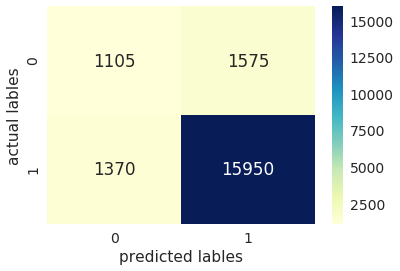

In [34]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [30]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.50      0.40      0.44      2680
          1       0.91      0.94      0.92     17320

avg / total       0.86      0.87      0.86     20000



## Top 20 features

In [35]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    print("Top 20 Features:")
    for (coef_1, fn_1) in top:
        print("")
        print("%-15s" % (fn_1))

In [36]:
show_most_informative_features(count_vect, DT_optimal)

Top 20 Features:

disappoint     

great          

worst          

best           

money          

horribl        

terribl        

love           

return         

delici         

bad            

wast           

good           

aw             

refund         

threw          

wont           

unfortun       

would          

product        


## Visualization of the tree

In [38]:
# For visualization.
DT_optimal_for_viz = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=5)
DT_optimal_for_viz.fit(X_test_bow, Y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
dot_data = tree.export_graphviz(DT_optimal_for_viz,
                                feature_names=count_vect.get_feature_names(),
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('bow.png')

True

# TF-IDF

In [11]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_tfidf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)
X_train_tfidf.shape

(60000, 6691)

In [12]:
X_CV_tfidf = tf_idf_vect.transform(X_CV['CleanedText'].values)
X_CV_tfidf.shape

(20000, 6691)

In [13]:
X_test_tfidf = tf_idf_vect.transform(X_test['CleanedText'].values)
X_test_tfidf.shape

(20000, 6691)

## Decision Trees on TF-IDF

In [14]:
tuned_parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split':[5, 10, 100, 500]}


DT_model = DecisionTreeClassifier(class_weight='balanced')
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_tfidf, Y_train)

print(model.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=500, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


## From the above results it can be seen that optimal depth is 500 and optimal min_samples_split is 5 now getting the train scores and CV scores for different values of depth and min_samples_split.¶

In [17]:
def scores_for_depth(X, Y):
    max_depths = [1, 5, 10, 50, 100, 500, 1000]
    scores =[]
    for max_depth in tqdm(max_depths):
            clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, min_samples_split=5)
            clf.fit(X_train_tfidf, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [18]:
CV_scores_depth = scores_for_depth(X_CV_tfidf, Y_CV)

100%|██████████| 7/7 [02:10<00:00, 18.70s/it]


In [19]:
train_scores_depth = scores_for_depth(X_train_tfidf, Y_train)

100%|██████████| 7/7 [02:05<00:00, 17.99s/it]


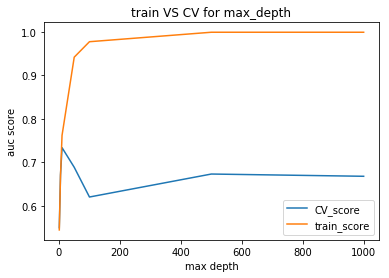

In [20]:
max_depths = [1, 5, 10, 50, 100, 500, 1000]
plt.plot(max_depths, CV_scores_depth, label='CV_score')
plt.plot(max_depths, train_scores_depth, label='train_score')
plt.title('train VS CV for max_depth')
plt.ylabel('auc score')
plt.xlabel('max depth')
plt.legend()
plt.show()

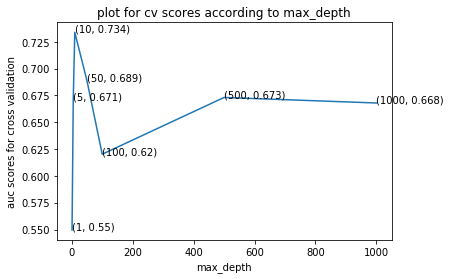

The auc score for each max_depth value for cross validation is :  [0.55  0.671 0.734 0.689 0.62  0.673 0.668]


In [21]:
plt.plot(max_depths, CV_scores_depth)

plt.title('plot for cv scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(CV_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each max_depth value for cross validation is : ", np.round(CV_scores_depth,3))

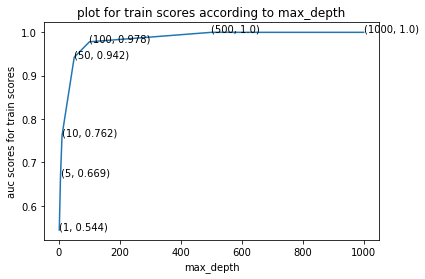

The auc score for each max_depth value for train data is :  [0.544 0.669 0.762 0.942 0.978 1.    1.   ]


In [22]:
plt.plot(max_depths, train_scores_depth)

plt.title('plot for train scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(train_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each max_depth value for train data is : ", np.round(train_scores_depth,3))

In [23]:
def scores_for_splits(X, Y):
    min_samples_splits=[5, 10, 100, 500]
    scores =[]
    for min_samples_split in tqdm(min_samples_splits):
            clf = DecisionTreeClassifier(criterion='gini', max_depth=500, min_samples_split=min_samples_split)
            clf.fit(X_train_tfidf, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [24]:
CV_scores_splits = scores_for_splits(X_CV_tfidf, Y_CV)

100%|██████████| 4/4 [02:39<00:00, 39.87s/it]


In [25]:
train_scores_splits = scores_for_splits(X_train_tfidf, Y_train)

100%|██████████| 4/4 [02:35<00:00, 38.91s/it]


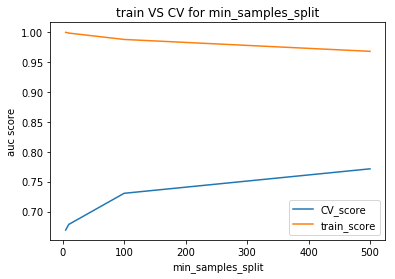

In [26]:
min_samples_splits=[5, 10, 100, 500]
plt.plot(min_samples_splits, CV_scores_splits, label='CV_score')
plt.plot(min_samples_splits, train_scores_splits, label='train_score')
plt.title('train VS CV for min_samples_split')
plt.ylabel('auc score')
plt.xlabel('min_samples_split')
plt.legend()
plt.show()

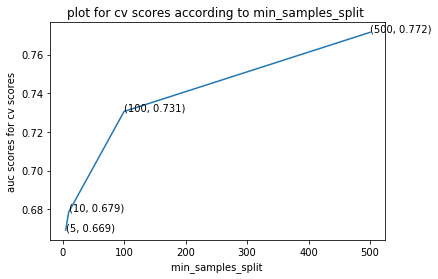

The auc score for each min_samples_split  value for cv data is :  [0.669 0.679 0.731 0.772]


In [27]:
plt.plot(min_samples_splits, CV_scores_splits)

plt.title('plot for cv scores according to min_samples_split ')
for xy in zip(np.round(min_samples_splits, 2), np.round(CV_scores_splits,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('min_samples_split ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each min_samples_split  value for cv data is : ", np.round(CV_scores_splits,3))

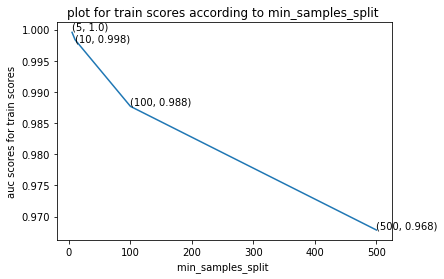

The auc score for each min_samples_split  value for train data is :  [1.    0.998 0.988 0.968]


In [28]:
plt.plot(min_samples_splits, train_scores_splits)

plt.title('plot for train scores according to min_samples_split ')
for xy in zip(np.round(min_samples_splits, 2), np.round(train_scores_splits,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('min_samples_split ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each min_samples_split  value for train data is : ", np.round(train_scores_splits,3))

## Getting the test data scores

In [29]:
DT_optimal = DecisionTreeClassifier(criterion='gini', max_depth=500, min_samples_split=5)

# fitting the model
DT_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred = DT_optimal.predict_proba(X_test_tfidf)[:, 1]

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [30]:
print('\nThe auc score for test data for max_depth = {} and min_samples_split = {} is {:2f}'.format(500, 5, auc_score))


The auc score for test data for max_depth = 500 and min_samples_split = 5 is 0.661930


In [31]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 1079,  1601],
       [ 1364, 15956]])

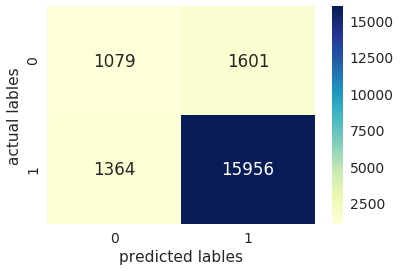

In [32]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [33]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.44      0.40      0.42      2680
          1       0.91      0.92      0.91     17320

avg / total       0.85      0.85      0.85     20000



## Top 20 features

In [34]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    print("Top 20 Features:")
    for (coef_1, fn_1) in top:
        print("")
        print("%-15s" % (fn_1))

In [35]:
show_most_informative_features(tf_idf_vect, DT_optimal)

Top 20 Features:

disappoint     

worst          

great          

best           

love           

wast           

bad            

return         

terribl        

horribl        

tast           

good           

delici         

aw             

would          

like           

money          

refund         

stale          

product        


## Visualizing the tree

In [38]:
# For visualization.
DT_optimal_for_viz = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=5)
DT_optimal_for_viz.fit(X_test_tfidf, Y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [39]:
dot_data = tree.export_graphviz(DT_optimal_for_viz,
                                feature_names=tf_idf_vect.get_feature_names(),
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tfidf.png')

True

# W2V

In [10]:
i=0
list_of_sent =[]
for sent in X_train['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

In [11]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [12]:
w2v_words = list(w2v_model.wv.vocab)

# Average W2V

In [13]:
X_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)
print(len(X_train_avgw2v))
print(len(X_train_avgw2v[0]))

100%|██████████| 60000/60000 [02:57<00:00, 338.14it/s]

60000
50


In [14]:
X_train_avgw2v = np.asarray(X_train_avgw2v)

In [15]:
X_train_avgw2v = StandardScaler().fit_transform(X_train_avgw2v)

In [16]:
i=0
list_of_sentence =[]
for sent in X_CV['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [17]:
X_CV_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_CV_avgw2v.append(sent_vec)
print(len(X_CV_avgw2v))
print(len(X_CV_avgw2v[0]))

100%|██████████| 20000/20000 [01:04<00:00, 309.60it/s]

20000
50


In [18]:
X_CV_avgw2v = np.asarray(X_CV_avgw2v)
X_CV_avgw2v = StandardScaler().fit_transform(X_CV_avgw2v)
X_CV_avgw2v.shape

(20000, 50)

In [19]:
i=0
list_of_sen =[]
for sent in X_test['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [20]:
X_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sen): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)
print(len(X_test_avgw2v))
print(len(X_test_avgw2v[0]))

100%|██████████| 20000/20000 [01:03<00:00, 316.57it/s]

20000
50


In [21]:
X_test_avgw2v = np.asarray(X_test_avgw2v)
X_test_avgw2v = StandardScaler().fit_transform(X_test_avgw2v)
X_test_avgw2v.shape

(20000, 50)

In [22]:
test_w2v = open("test_w2v.pickle", "wb")
pickle.dump(X_test_avgw2v, test_w2v)
test_w2v.close()

## Decision Trees on Average W2V

In [23]:
tuned_parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split':[5, 10, 100, 500]}


DT_model = DecisionTreeClassifier(class_weight='balanced')
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='f1',cv=5,n_jobs=-1)

model.fit(X_train_avgw2v, Y_train)

print(model.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


## From the above results it can be seen that optimal depth is 100 and optimal min_samples_split is 5 now getting the train scores and CV scores for different values of depth and min_samples_split.

In [24]:
def scores_for_depth(X, Y):
    max_depths = [1, 5, 10, 50, 100, 500, 1000]
    scores =[]
    for max_depth in tqdm(max_depths):
            clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, min_samples_split=5, min_samples_leaf=5)
            clf.fit(X_train_avgw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [25]:
CV_scores_depth = scores_for_depth(X_CV_avgw2v, Y_CV)

100%|██████████| 7/7 [00:28<00:00,  4.06s/it]


In [27]:
train_scores_depth = scores_for_depth(X_train_avgw2v, Y_train)

100%|██████████| 7/7 [00:27<00:00,  3.91s/it]


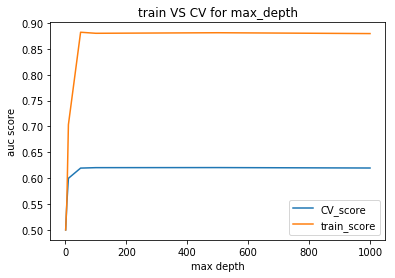

In [28]:
max_depths = [1, 5, 10, 50, 100, 500, 1000]
plt.plot(max_depths, CV_scores_depth, label='CV_score')
plt.plot(max_depths, train_scores_depth, label='train_score')
plt.title('train VS CV for max_depth')
plt.ylabel('auc score')
plt.xlabel('max depth')
plt.legend()
plt.show()

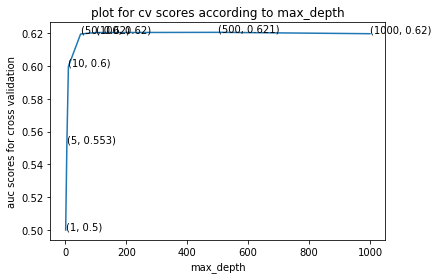

The auc score for each max_depth value for cross validation is :  [0.5   0.553 0.6   0.62  0.62  0.621 0.62 ]


In [30]:
plt.plot(max_depths, CV_scores_depth)

plt.title('plot for cv scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(CV_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each max_depth value for cross validation is : ", np.round(CV_scores_depth,3))

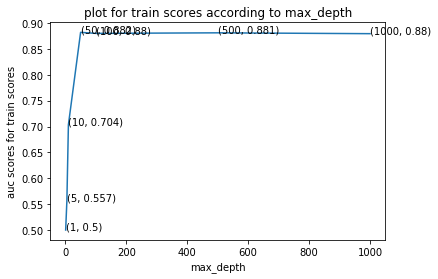

The auc score for each max_depth value for train data is :  [0.5   0.557 0.704 0.882 0.88  0.881 0.88 ]


In [31]:
plt.plot(max_depths, train_scores_depth)

plt.title('plot for train scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(train_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each max_depth value for train data is : ", np.round(train_scores_depth,3))

In [32]:
def scores_for_splits(X, Y):
    min_samples_splits=[5, 10, 100, 500]
    scores =[]
    for min_samples_split in tqdm(min_samples_splits):
            clf = DecisionTreeClassifier(criterion='gini', max_depth=100, min_samples_split=min_samples_split, min_samples_leaf=5)
            clf.fit(X_train_avgw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [33]:
CV_scores_splits = scores_for_splits(X_CV_avgw2v, Y_CV)

100%|██████████| 4/4 [00:20<00:00,  5.10s/it]


In [34]:
train_scores_splits = scores_for_splits(X_train_avgw2v, Y_train)

100%|██████████| 4/4 [00:19<00:00,  4.90s/it]


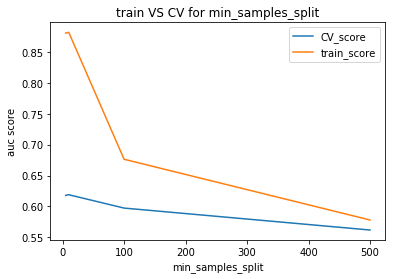

In [35]:
min_samples_splits=[5, 10, 100, 500]
plt.plot(min_samples_splits, CV_scores_splits, label='CV_score')
plt.plot(min_samples_splits, train_scores_splits, label='train_score')
plt.title('train VS CV for min_samples_split')
plt.ylabel('auc score')
plt.xlabel('min_samples_split')
plt.legend()
plt.show()

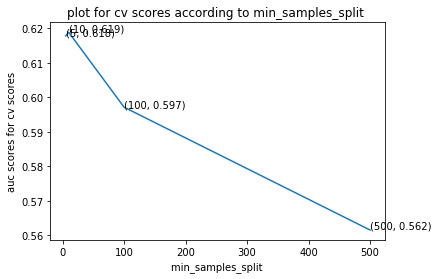

The auc score for each min_samples_split  value for cv data is :  [0.618 0.619 0.597 0.562]


In [36]:
plt.plot(min_samples_splits, CV_scores_splits)

plt.title('plot for cv scores according to min_samples_split ')
for xy in zip(np.round(min_samples_splits, 2), np.round(CV_scores_splits,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('min_samples_split ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each min_samples_split  value for cv data is : ", np.round(CV_scores_splits,3))

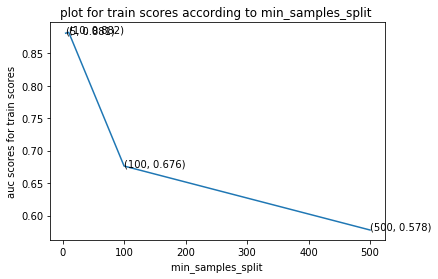

The auc score for each min_samples_split  value for train data is :  [0.881 0.882 0.676 0.578]


In [37]:
plt.plot(min_samples_splits, train_scores_splits)

plt.title('plot for train scores according to min_samples_split ')
for xy in zip(np.round(min_samples_splits, 2), np.round(train_scores_splits,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('min_samples_split ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each min_samples_split  value for train data is : ", np.round(train_scores_splits,3))

## Getting the test data scores.

In [38]:
DT_optimal = DecisionTreeClassifier(criterion='gini', max_depth=100, min_samples_split=5, min_samples_leaf=5)

# fitting the model
DT_optimal.fit(X_train_avgw2v, Y_train)

# predict the response
pred = DT_optimal.predict_proba(X_test_avgw2v)[:, 1]

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [39]:
print('\nThe auc score for test data for max_depth = {} and min_samples_split = {} is {:2f}'.format(100, 5, auc_score))


The auc score for test data for max_depth = 100 and min_samples_split = 5 is 0.611215


In [40]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  818,  1862],
       [ 1434, 15886]])

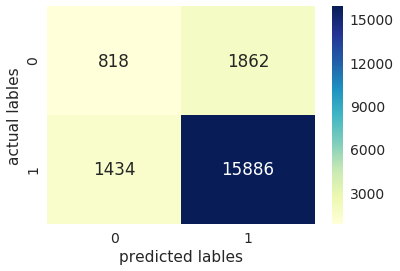

In [41]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [42]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.36      0.31      0.33      2680
          1       0.90      0.92      0.91     17320

avg / total       0.82      0.84      0.83     20000



# TF-IDF W2V 

In [11]:
i=0
list_of_sent =[]
for sent in X_train['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


In [12]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [13]:
w2v_words = list(w2v_model.wv.vocab)

In [14]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [15]:
tfidf_feat = model.get_feature_names()

X_train_tf = []
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tf.append(sent_vec)
    row += 1

100%|██████████| 60000/60000 [01:44<00:00, 576.53it/s]


In [16]:
X_train_tfidfw2v = np.asarray(X_train_tf)
X_train_tfidfw2v = StandardScaler().fit_transform(X_train_tfidfw2v)
X_train_tfidfw2v.shape

(60000, 50)

In [17]:
train_tfidfw2v = open("train_tfidfw2v.pickle", "wb")
pickle.dump(X_train_tfidfw2v, train_tfidfw2v)
train_tfidfw2v.close()

In [18]:
i=0
list_of_sentence =[]
for sent in X_CV['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [19]:
X_CV_tfidf = model.transform(X_CV['CleanedText'].values)

In [20]:
tfidf_feat = model.get_feature_names()

X_CV_tf = []
row=0;
for sent in tqdm(list_of_sentence):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_CV_tf.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:39<00:00, 506.26it/s]


In [21]:
X_CV_tfidfw2v = np.asarray(X_CV_tf)
X_CV_tfidfw2v = StandardScaler().fit_transform(X_CV_tfidfw2v)
X_CV_tfidfw2v.shape

(20000, 50)

In [22]:
i=0
list_of_sen =[]
for sent in X_test['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [23]:
X_test_tfidf = model.transform(X_test['CleanedText'].values)

In [24]:
tfidf_feat = model.get_feature_names()

X_test_tf = []
row=0;
for sent in tqdm(list_of_sen):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tf.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:36<00:00, 550.42it/s]


In [25]:
X_test_tfidfw2v = np.asarray(X_test_tf)
X_test_tfidfw2v = StandardScaler().fit_transform(X_test_tfidfw2v)
X_test_tfidfw2v.shape

(20000, 50)

## Decision Trees on TF-IDF weighted W2V

In [27]:
tuned_parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split':[5, 10, 100, 500]}


DT_model = DecisionTreeClassifier(class_weight='balanced')
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='f1',cv=3,n_jobs=-1)

model.fit(X_train_tfidfw2v, Y_train)

print(model.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=100, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


## From the above results it can be seen that optimal depth is 100 and optimal min_samples_split is 5 now getting the train scores and CV scores for different values of depth and min_samples_split.

In [28]:
def scores_for_depth(X, Y):
    max_depths = [1, 5, 10, 50, 100, 500, 1000]
    scores =[]
    for max_depth in tqdm(max_depths):
            clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, min_samples_split=5, min_samples_leaf=5)
            clf.fit(X_train_tfidfw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [29]:
CV_scores_depth = scores_for_depth(X_CV_tfidfw2v, Y_CV)

100%|██████████| 7/7 [00:30<00:00,  4.39s/it]


In [31]:
train_scores_depth = scores_for_depth(X_train_tfidfw2v, Y_train)

100%|██████████| 7/7 [00:29<00:00,  4.26s/it]


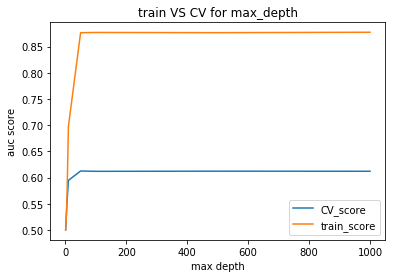

In [32]:
max_depths = [1, 5, 10, 50, 100, 500, 1000]
plt.plot(max_depths, CV_scores_depth, label='CV_score')
plt.plot(max_depths, train_scores_depth, label='train_score')
plt.title('train VS CV for max_depth')
plt.ylabel('auc score')
plt.xlabel('max depth')
plt.legend()
plt.show()

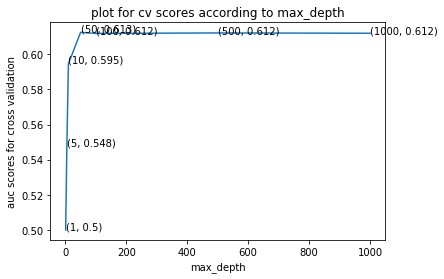

The auc score for each max_depth value for cross validation is :  [0.5   0.548 0.595 0.613 0.612 0.612 0.612]


In [33]:
plt.plot(max_depths, CV_scores_depth)

plt.title('plot for cv scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(CV_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each max_depth value for cross validation is : ", np.round(CV_scores_depth,3))

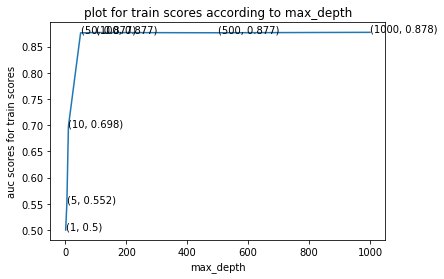

The auc score for each max_depth value for train data is :  [0.5   0.552 0.698 0.877 0.877 0.877 0.878]


In [34]:
plt.plot(max_depths, train_scores_depth)

plt.title('plot for train scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(train_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each max_depth value for train data is : ", np.round(train_scores_depth,3))

In [38]:
def scores_for_splits(X, Y):
    min_samples_splits=[5, 10, 100, 500]
    scores =[]
    for min_samples_split in tqdm(min_samples_splits):
            clf = DecisionTreeClassifier(criterion='gini', max_depth=500, min_samples_split=min_samples_split, min_samples_leaf=5)
            clf.fit(X_train_tfidfw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [39]:
CV_scores_splits = scores_for_splits(X_CV_tfidfw2v, Y_CV)

100%|██████████| 4/4 [00:22<00:00,  5.68s/it]


In [40]:
train_scores_splits = scores_for_splits(X_train_tfidfw2v, Y_train)

100%|██████████| 4/4 [00:22<00:00,  5.63s/it]


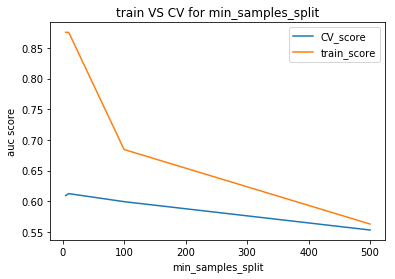

In [41]:
min_samples_splits=[5, 10, 100, 500]
plt.plot(min_samples_splits, CV_scores_splits, label='CV_score')
plt.plot(min_samples_splits, train_scores_splits, label='train_score')
plt.title('train VS CV for min_samples_split')
plt.ylabel('auc score')
plt.xlabel('min_samples_split')
plt.legend()
plt.show()

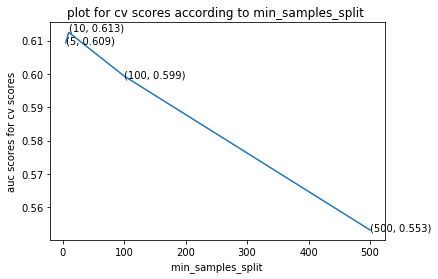

The auc score for each min_samples_split  value for cv data is :  [0.609 0.613 0.599 0.553]


In [42]:
plt.plot(min_samples_splits, CV_scores_splits)

plt.title('plot for cv scores according to min_samples_split ')
for xy in zip(np.round(min_samples_splits, 2), np.round(CV_scores_splits,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('min_samples_split ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each min_samples_split  value for cv data is : ", np.round(CV_scores_splits,3))

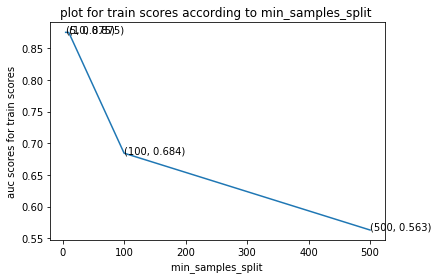

The auc score for each min_samples_split  value for train data is :  [0.875 0.875 0.684 0.563]


In [43]:
plt.plot(min_samples_splits, train_scores_splits)

plt.title('plot for train scores according to min_samples_split ')
for xy in zip(np.round(min_samples_splits, 2), np.round(train_scores_splits,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('min_samples_split ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each min_samples_split  value for train data is : ", np.round(train_scores_splits,3))

## Getting the test data scores

In [44]:
DT_optimal = DecisionTreeClassifier(criterion='gini', max_depth=100, min_samples_split=5, min_samples_leaf=5)

# fitting the model
DT_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = DT_optimal.predict_proba(X_test_tfidfw2v)[:, 1]

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [45]:
print('\nThe auc score for test data for max_depth = {} and min_samples_split = {} is {:2f}'.format(100, 5, auc_score))


The auc score for test data for max_depth = 100 and min_samples_split = 5 is 0.616668


In [46]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  861,  1819],
       [ 1523, 15797]])

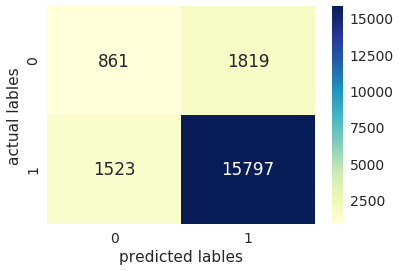

In [47]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [48]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.36      0.32      0.34      2680
          1       0.90      0.91      0.90     17320

avg / total       0.82      0.83      0.83     20000



# Comparison of all the models.

In [40]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Max Depth", "min_samples_split", "AUC-Score on the test data"]
x.add_row(['BOW', 'Decision Tree', 1000, 5, '0.6666'])
x.add_row(['TF-IDF', 'Decision Tree', 500, 5, '0.6619'])
x.add_row(['Average W2V', 'Decision Tree',100, 5, '0.6112'])
x.add_row(['TF-IDF Weighted W2V', 'Decision Tree', 100, 5, '0.6166'])
print(x)

+---------------------+---------------+-----------+-------------------+----------------------------+
|      Vectorizer     |     Model     | Max Depth | min_samples_split | AUC-Score on the test data |
+---------------------+---------------+-----------+-------------------+----------------------------+
|         BOW         | Decision Tree |    1000   |         5         |           0.6666           |
|        TF-IDF       | Decision Tree |    500    |         5         |           0.6619           |
|     Average W2V     | Decision Tree |    100    |         5         |           0.6112           |
| TF-IDF Weighted W2V | Decision Tree |    100    |         5         |           0.6166           |
+---------------------+---------------+-----------+-------------------+----------------------------+


## Thus, from the above table we can see that the model with BOW vectorizer performed better.